In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Step 1: Generate a sample user-item matrix
np.random.seed(42)
num_users = 50
num_items = 20
user_item_matrix = pd.DataFrame(
    np.random.randint(1, 6, size=(num_users, num_items)),
    index=[f"User_{i}" for i in range(num_users)],
    columns=[f"Item_{j}" for j in range(num_items)]
)
user_item_matrix.iloc[::5, ::4] = np.nan  # Introduce some missing values

# Step 2: Train-test split
train_data, test_data = train_test_split(user_item_matrix, test_size=0.2, random_state=42)

# Step 3: Define collaborative filtering prediction function
def collaborative_filtering_predict(user_item_matrix, mode="user", top_k=5):
    if mode == "user":
        similarity_matrix = cosine_similarity(user_item_matrix.fillna(0))
        similarity_matrix = pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)
    else:  # Item-based
        similarity_matrix = cosine_similarity(user_item_matrix.fillna(0).T)
        similarity_matrix = pd.DataFrame(similarity_matrix, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    predictions = user_item_matrix.copy()
    for user in user_item_matrix.index:
        for item in user_item_matrix.columns:
            if pd.isna(user_item_matrix.loc[user, item]):
                if mode == "user":
                    similar_users = similarity_matrix[user].nlargest(top_k + 1).iloc[1:]  # Exclude self
                    weights = similar_users.values
                    ratings = user_item_matrix.loc[similar_users.index, item]
                else:  # Item-based
                    similar_items = similarity_matrix[item].nlargest(top_k + 1).iloc[1:]  # Exclude self
                    weights = similar_items.values
                    ratings = user_item_matrix.loc[user, similar_items.index]

                if ratings.notna().sum() > 0:
                    predictions.loc[user, item] = np.dot(weights, ratings.fillna(0)) / np.sum(weights)
                else:
                    predictions.loc[user, item] = np.nan
    return predictions

# Step 4: Define evaluation function
def evaluate_predictions(predictions, actuals):
    predictions_aligned = predictions.loc[actuals.index, actuals.columns].fillna(0)  # Fill NaN in predictions
    actuals_aligned = actuals.fillna(0)  # Fill NaN in actuals

    y_true = actuals_aligned.values.flatten()
    y_pred = predictions_aligned.values.flatten()

    if len(y_true) == 0 or len(y_pred) == 0:
        print("No valid samples for evaluation.")
        return {"MAE": None, "RMSE": None}

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {"MAE": mae, "RMSE": rmse}

# Step 5: Baseline prediction (average-based)
def average_based_predict(user_item_matrix):
    item_means = user_item_matrix.mean(axis=0)
    avg_predictions = pd.DataFrame(
        [item_means.values] * user_item_matrix.shape[0],
        index=user_item_matrix.index,
        columns=user_item_matrix.columns
    )
    return avg_predictions

# Step 6: Make predictions
avg_predictions = average_based_predict(train_data)
cofilter_predictions = collaborative_filtering_predict(train_data, mode="user", top_k=5)

# Step 7: Evaluate predictions
test_data_aligned = test_data.reindex_like(user_item_matrix)
avg_predictions_aligned = avg_predictions.reindex_like(test_data_aligned)
cofilter_predictions_aligned = cofilter_predictions.reindex_like(test_data_aligned)

avg_eval = evaluate_predictions(avg_predictions_aligned, test_data_aligned)
cofilter_eval = evaluate_predictions(cofilter_predictions_aligned, test_data_aligned)

# Step 8: Display results
print("Performance Comparison:")
if avg_eval["MAE"] is not None and avg_eval["RMSE"] is not None:
    print(f"Baseline (Average-based): MAE = {avg_eval['MAE']:.4f}") #, RMSE = {avg_eval['RMSE']:.4f}
else:
    print("Baseline (Average-based): No valid samples for evaluation.")

if cofilter_eval["MAE"] is not None and cofilter_eval["RMSE"] is not None:
    print(f"Collaborative Filtering: MAE = {cofilter_eval['MAE']:.4f}") #, RMSE = {cofilter_eval['RMSE']:.4f}
else:
    print("Collaborative Filtering: No valid samples for evaluation.")


Performance Comparison:
Baseline (Average-based): MAE = 2.9475
Collaborative Filtering: MAE = 2.8784


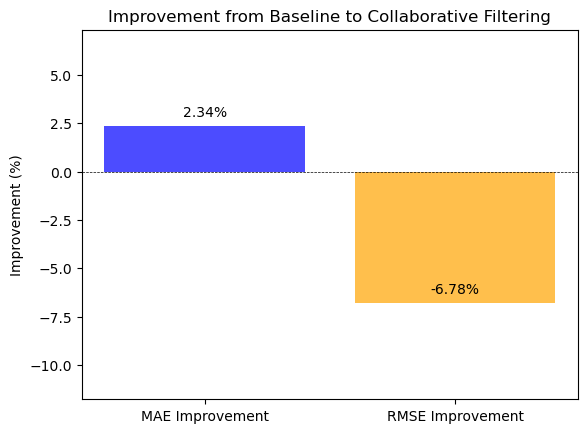

In [21]:
import matplotlib.pyplot as plt

# Calculate improvement percentages
mae_improvement = ((avg_eval['MAE'] - cofilter_eval['MAE']) / avg_eval['MAE']) * 100
rmse_improvement = ((avg_eval['RMSE'] - cofilter_eval['RMSE']) / avg_eval['RMSE']) * 100

# Data for the plot
metrics = ["MAE Improvement", "RMSE Improvement"]
improvement_values = [mae_improvement, rmse_improvement]

# Plotting
plt.bar(metrics, improvement_values, color=["blue", "orange"], alpha=0.7)
plt.title("Improvement from Baseline to Collaborative Filtering")
plt.ylabel("Improvement (%)")
plt.ylim(min(improvement_values) - 5, max(improvement_values) + 5)  # Adjust Y-axis for clarity
for i, val in enumerate(improvement_values):
    plt.text(i, val + 0.5, f"{val:.2f}%", ha='center', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Reference line at 0
plt.show()
